In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import mxnet as mx
from mxnet import nd, autograd, gluon

from sklearn import preprocessing
from sklearn.metrics import f1_score

nab_path = './NAB'
labels_path = nab_path + '/labels/combined_labels.json'
nab_data_path = nab_path + '/data/'

### Load labels

In [3]:
labels_file = open(labels_path, 'r')
labels = json.loads(labels_file.read())
labels_file.close()

# TODO output labels

### Load training dataset

In [312]:
def load_data_frame(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(labels[file_name]).astype(int)
    return data_frame

training_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

training_data_frame = load_data_frame(training_file_name)
training_data_frame.head()

,timestamp,value,anomaly_label
0,2014-04-10 00:02:00,14.012,0
1,2014-04-10 00:07:00,13.334,0
2,2014-04-10 00:12:00,15.000,0
3,2014-04-10 00:17:00,13.998,0
4,2014-04-10 00:22:00,14.332,0


In [313]:
training_data_frame.shape

(4032, 3)

In [314]:
test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

test_data_frame = load_data_frame(test_file_name)
test_data_frame.head()

,timestamp,value,anomaly_label
0,2014-02-14 14:30:00,6.456,0
1,2014-02-14 14:35:00,5.816,0
2,2014-02-14 14:40:00,6.268,0
3,2014-02-14 14:45:00,5.816,0
4,2014-02-14 14:50:00,5.862,0


In [315]:
test_data_frame.shape

(4032, 3)

### Make timestamp conversions

In [316]:
def convert_timestamps(data_frame):
    data_frame['timestamp'] = pd.to_datetime(data_frame['timestamp'])
    data_frame['time_epoch'] = (data_frame['timestamp'].astype(np.int64) / 100000000000).astype(np.int64)


convert_timestamps(training_data_frame)
convert_timestamps(test_data_frame)

### Plot data with anomaly_labels

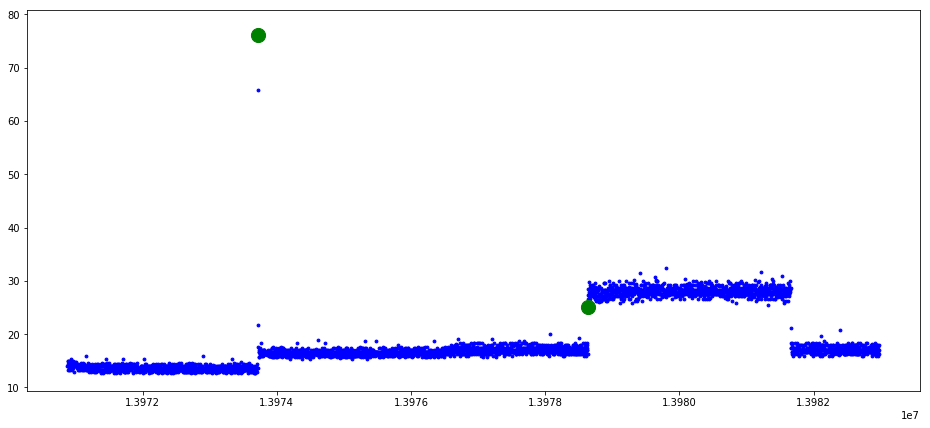

In [317]:
def plot(data_frame):
    fig, ax = plt.subplots()

    a = data_frame.loc[data_frame['anomaly_label'] == 1, ['time_epoch', 'value']]

    ax.scatter(data_frame['time_epoch'], data_frame['value'], s=8, color='blue')
    ax.scatter(a['time_epoch'], a['value'], s=200, color='green')
    plt.show()


figsize(16, 7)

plot(training_data_frame)

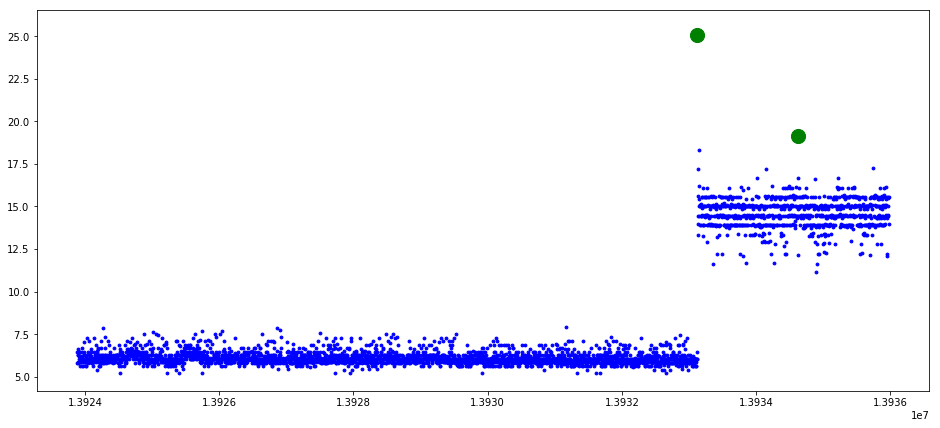

In [318]:
figsize(16, 7)

plot(test_data_frame)

### Scale the train data

In [391]:
feature_list = ['value']
features = len(feature_list)

# TODO add comment on scaler
min_max_scaler = preprocessing.StandardScaler()

training_data = training_data_frame[feature_list].values.astype(np.float32)
training_data = min_max_scaler.fit_transform(training_data)

### Prepare training and validation data

In [491]:
rows = len(training_data)

split_factor = 0.5

training = training_data[0:int(rows * split_factor)]
validation = training_data[int(rows * split_factor):]

In [492]:
ctx = mx.cpu()

In [493]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(features))
    model.add(mx.gluon.nn.Dense(features, activation='tanh'))


model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

In [494]:
L = gluon.loss.L2Loss()


def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 1, features))
        output = model(data)
        loss = L(output, data)
        loss_avg = (loss_avg * i + nd.mean(loss).asscalar()) / (i + 1)
    return loss_avg

In [495]:
epochs = 240
batch_size = 12


training_data_batches = mx.gluon.data.DataLoader(training, batch_size, shuffle=False)
validation_data_batches = mx.gluon.data.DataLoader(validation, batch_size, shuffle=False)


training_mse = []
validation_mse = []


for epoch in range(epochs):
    print(str(epoch+1))
    for i, data in enumerate(training_data_batches):
        data = data.as_in_context(ctx).reshape((-1, 1, features))

        with autograd.record():
            output = model(data)
            loss = L(output, data)

        loss.backward()
        trainer.step(batch_size)

    training_mse.append(evaluate_accuracy(training_data_batches, model, L))
    validation_mse.append(evaluate_accuracy(validation_data_batches, model, L))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


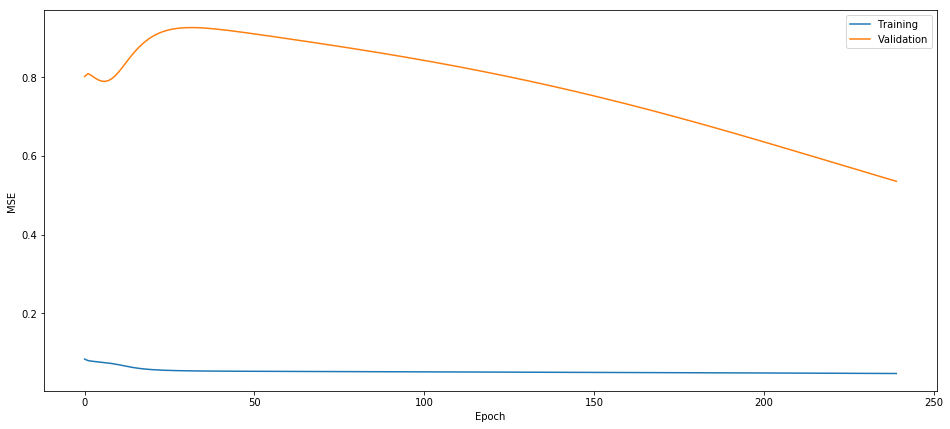

In [496]:
def plot_errors(train_mse, validate_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Training')
    plt.plot(epochs, validate_mse, label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


figsize(16, 7)
plot_errors(training_mse, validation_mse)

In [497]:
def calculate_reconstruction_errors(input_data, L):
    reconstruction_errors = []
    for i, data in enumerate(input_data):
        input = data.as_in_context(ctx).reshape((-1, features, 1))
        predicted_value = model(input)
        reconstruction_error = L(predicted_value, input).asnumpy().flatten()        
        reconstruction_errors = np.append(
            reconstruction_errors, reconstruction_error)

    return reconstruction_errors

In [498]:
all_training_data = mx.gluon.data.DataLoader(
    training_data.astype(np.float32), batch_size, shuffle=False)

training_reconstruction_errors = calculate_reconstruction_errors(all_training_data, L)
reconstruction_error_threshold = np.mean(training_reconstruction_errors) + 3 * \
                                 np.std(training_reconstruction_errors)

In [499]:
test_data = test_data_frame[feature_list].values.astype(np.float32)
test_data = min_max_scaler.fit_transform(test_data)

test_data_batches = mx.gluon.data.DataLoader(test_data, batch_size, shuffle=False)

test_reconstruction_errors = calculate_reconstruction_errors(test_data_batches, L)

predicted_test_anomalies = list(
    map(lambda v: 1 if v > reconstruction_error_threshold else 0, test_reconstruction_errors))

test_data_frame['anomaly_predicted'] = predicted_test_anomalies

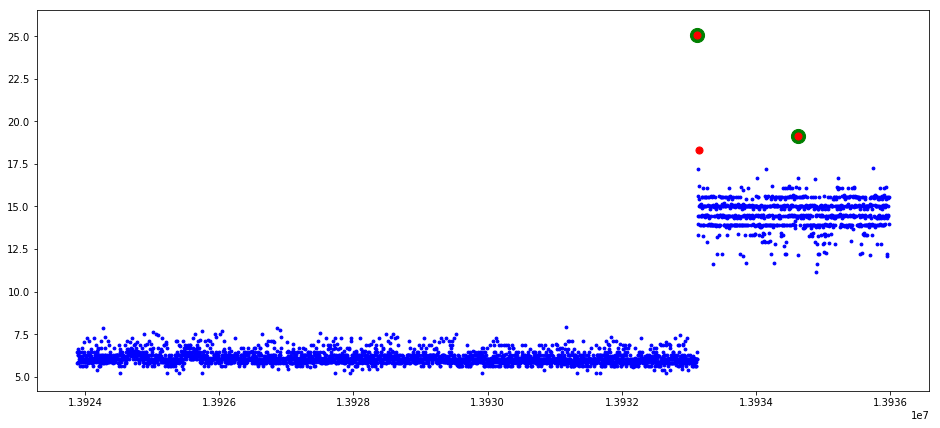

In [500]:
fig, ax = plt.subplots()
predicted_dots = test_data_frame.loc[test_data_frame['anomaly_predicted'] == 1, ['time_epoch', 'value']]
label_dots = test_data_frame.loc[test_data_frame['anomaly_label'] == 1, ['time_epoch', 'value']]

ax.scatter(test_data_frame['time_epoch'], test_data_frame['value'], s=8, color='blue')
ax.scatter(label_dots['time_epoch'], label_dots['value'], s=200, color='green')
ax.scatter(predicted_dots['time_epoch'], predicted_dots['value'], s=50, color='red')

figsize(16, 7)
plt.show()

In [501]:
test_labels = test_data_frame['anomaly_label'].astype(np.int64)

f_score = f1_score(test_labels, predicted_test_anomalies)
print('F1 score: ' + str(f_score))

F1 score: 0.8
